In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('../data/portland/total.csv')

**Load Data**

In [3]:
print('train: ' + str(train.shape))

train: (2584, 23)


In [4]:
train.columns = ['link', 'image', 'addr', 'zip', 'redfin_price', 'sold_price', 'Beds', 'Bath', 'SqFt', 'YearBuilt', 'SoldTime', 'Disc', 'Stories', 'Style', 'Community', 'County', 'LotSize', 'ElemSchool', 'MidSchool', 'HighSchool', 'Walk', 'Transit', 'Bike']

In [5]:
new_df = train.dropna()

In [6]:
print(new_df.shape)

(1063, 23)


In [7]:
new_df.zip = new_df.zip.str.extract(r'(\d+)').astype('int')
new_df.redfin_price = new_df.redfin_price.str.replace(r'$', '')
new_df.redfin_price = new_df.redfin_price.str.replace(r',', '').astype('int')
new_df.sold_price = new_df.sold_price.str.replace(r'$', '')
new_df.sold_price = new_df.sold_price.str.replace(r',', '').astype('int')
new_df.SqFt = new_df.SqFt.str.replace(r',', '').astype('int')
new_df.YearBuilt = new_df.YearBuilt.astype('int')
#new_df.Stories = new_df.Stories.astype('int')
new_df.ElemSchool = new_df.ElemSchool.astype('int')
new_df.MidSchool = new_df.MidSchool.astype('int')
new_df.HighSchool = new_df.HighSchool.astype('int')
new_df.Walk = new_df.Walk.str.extract(r'(\d+)\s*/\s*100').astype('int')
new_df.Transit = new_df.Transit.str.extract(r'(\d+)\s*/\s*100').astype('int')
new_df.Bike = new_df.Bike.str.extract(r'(\d+)\s*/\s*100').astype('int')

/home/ooo/projects/packages/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Take log on sales price

In [8]:
new_df.sold_price = np.log(new_df.sold_price + 1)

/home/ooo/projects/packages/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


**Find Most Important Features**

In [9]:
corr = new_df.corr()
corr.sort_values(['sold_price'], ascending=False, inplace=True)
print(corr.sold_price)

sold_price      1.000000
redfin_price    0.942147
SqFt            0.739628
ElemSchool      0.635460
MidSchool       0.516681
HighSchool      0.475760
Walk            0.319470
Bike            0.269988
Transit         0.072679
YearBuilt      -0.064907
zip            -0.518784
Name: sold_price, dtype: float64


**Build Features**

In [10]:
numerical_features = new_df.select_dtypes(exclude = [object]).columns
numerical_features = numerical_features.drop('sold_price')
numerical_features = numerical_features.drop('redfin_price')
categorical_features = new_df.select_dtypes(include = ['object']).columns
print('total_features: %d' % train.shape[1])
print('numerical_features: %d' % len(numerical_features))
print('categorical_features: %d' % len(categorical_features))
train_num = new_df[numerical_features]

total_features: 23
numerical_features: 9
categorical_features: 12


handle remaining missing values for numerical features by using median as replacement

In [11]:
print('total_null_values: %d' % train_num.isnull().values.sum())
train_num = train_num.fillna(train_num.median())
print('total_null_values: %d' % train_num.isnull().values.sum())

total_null_values: 0
total_null_values: 0


In [12]:
temp_set = train_num
print('temp set dimension: ' + str(temp_set.shape))

temp set dimension: (1063, 9)


**Build Train and Dev Set**

In [13]:
train_set, dev_set, train_set_label, dev_set_label = train_test_split(temp_set, new_df.sold_price, test_size=0.3, random_state=0)
print("train set dimension: " + str(train_set.shape))
print("dev set dimension: " + str(dev_set.shape))
print("train set label: " + str(train_set_label.shape))
print("dev set label: " + str(dev_set_label.shape))

train set dimension: (744, 9)
dev set dimension: (319, 9)
train set label: (744,)
dev set label: (319,)


**Cost Function**

In [14]:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, train_set, train_set_label, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_dev(model):
    rmse= np.sqrt(-cross_val_score(model, dev_set, dev_set_label, scoring = scorer, cv = 10))
    return(rmse)

In [17]:
from sklearn.metrics import r2_score

scorer2 = make_scorer(r2_score, greater_is_better = False)

def r2_cv_train(model):
    r2= -cross_val_score(model, train_set, train_set_label, scoring = scorer2, cv = 10)
    return(r2)

def r2_cv_dev(model):
    r2= -cross_val_score(model, dev_set, dev_set_label, scoring = scorer2, cv = 10)
    return(r2)

**Linear Regression**

In [18]:
lr = LinearRegression()
lr.fit(train_set, train_set_label)

print('RMSE at Training Set: %.3f' % rmse_cv_train(lr).mean())
print('RMSE at Dev Set: %.3f' % rmse_cv_dev(lr).mean())
print('R2 at Training Set: %.3f' % r2_cv_train(lr).mean())
print('R2 at Dev Set: %.3f' % r2_cv_dev(lr).mean())

RMSE at Training Set: 0.176
RMSE at Dev Set: 0.170
R2 at Training Set: 0.755
R2 at Dev Set: 0.723


**Plot Predictions**

In [19]:
train_set_pred = lr.predict(train_set)
dev_set_pred = lr.predict(dev_set)

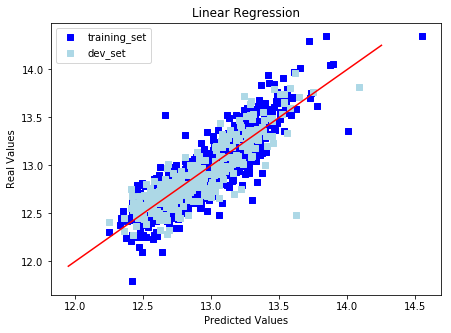

In [20]:
plt.figure(1, figsize=(7, 5))
plt.scatter(train_set_pred, train_set_label, c = "blue", marker = "s", label = "training_set")
plt.scatter(dev_set_pred, dev_set_label, c = "lightblue", marker = "s", label = "dev_set")
plt.title("Linear Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Real Values")
plt.legend(loc = "upper left")
plt.plot([11.95, 14.25], [11.95, 14.25], c = "red")
plt.show()

**XGBoost**

In [21]:
from xgboost import XGBRegressor

In [22]:
xgb = XGBRegressor()

In [23]:
xgb.fit(train_set, train_set_label, verbose=True)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [24]:
print('RMSE at Training Set: %.3f' % rmse_cv_train(xgb).mean())
print('RMSE at Dev Set: %.3f' % rmse_cv_dev(xgb).mean())
print('R2 at Training Set: %.3f' % r2_cv_train(xgb).mean())
print('R2 at Dev Set: %.3f' % r2_cv_dev(xgb).mean())

RMSE at Training Set: 0.159
RMSE at Dev Set: 0.171
R2 at Training Set: 0.800
R2 at Dev Set: 0.720


**Plot Predictions**

In [40]:
train_set_pred = xgb.predict(train_set)
dev_set_pred = xgb.predict(dev_set)

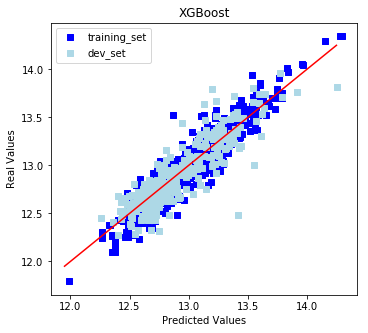

In [42]:
plt.figure(1, figsize=(5.5, 5))
plt.scatter(train_set_pred, train_set_label, c = "blue", marker = "s", label = "training_set")
plt.scatter(dev_set_pred, dev_set_label, c = "lightblue", marker = "s", label = "dev_set")
plt.title("XGBoost")
plt.xlabel("Predicted Values")
plt.ylabel("Real Values")
plt.legend(loc = "upper left")
plt.plot([11.95, 14.25], [11.95, 14.25], c = "red")
plt.show()